In [11]:
# @title L matrix
import numpy as np

def gauss_quadrature_points_weights(n_points):
    if n_points == 2:
        points = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
        weights = np.array([1, 1])
    elif n_points == 3:
        points = np.array([-np.sqrt(3 / 5), 0, np.sqrt(3 / 5)])
        weights = np.array([5 / 9, 8 / 9, 5 / 9])
    else:
        raise ValueError("Gauss quadrature for the given number of points is not implemented.")
    return points, weights


def shape_functions(xi):
    return np.array([(1 - xi) / 2, (1 + xi) / 2])

def dshape_functions(xi):
    return np.array([-0.5, 0.5])

def jacobian_and_inverse(x_element):
    element_length = x_element[1] - x_element[0]
    jacobian = element_length / 2
    jac_inv = 2 / element_length
    return jacobian, jac_inv

def compute_element_L_matrix(x_element, num_gauss_points):
    jacobian, jac_inv = jacobian_and_inverse(x_element)
    num_nodes = 2
    L_element = np.zeros((num_nodes, num_nodes))
    gauss_points, gauss_weights = gauss_quadrature_points_weights(num_gauss_points)
    for i in range(num_nodes):
        for j in range(num_nodes):
            integral = 0
            for k, xi in enumerate(gauss_points):
                weight = gauss_weights[k]
                Bi = dshape_functions(xi)[i] * jac_inv
                Bj = dshape_functions(xi)[j] * jac_inv
                integral += weight * Bi * Bj * jacobian
            L_element[i, j] = integral
    return L_element

def assemble_global_L_matrix(x_nodes, num_gauss_points):
    num_nodes = len(x_nodes)
    num_elements = num_nodes - 1
    L_global = np.zeros((num_nodes, num_nodes))

    for e in range(num_elements):
        x_element = x_nodes[e:e + 2]
        L_element = compute_element_L_matrix(x_element, num_gauss_points)

        for i in range(2):
            for j in range(2):
                L_global[e + i, e + j] += L_element[i, j]
    return L_global

In [12]:
# @title M matrix New
def compute_M_matrix(x_nodes, v, num_gauss_points):
    num_nodes = len(x_nodes)
    num_elements = num_nodes - 1
    M = np.zeros((num_nodes, num_nodes))

    for elem in range(num_elements):
        x_elem = x_nodes[elem:elem + 2]
        v_elem = v[elem:elem + 2]
        jacobian = (x_elem[1] - x_elem[0]) / 2
        jac_inv = 1 / jacobian

        M_local = np.zeros((2, 2))

        gauss_points, gauss_weights = gauss_quadrature_points_weights(num_gauss_points)
        for k in range(num_gauss_points):
            xi = gauss_points[k]
            weight = gauss_weights[k]


            phi = shape_functions(xi)
            B = dshape_functions(xi) * jac_inv


            B_dot_v = np.dot(B, v_elem)

            Bt_phi = np.outer(B, phi)

            M_local += B_dot_v * Bt_phi * weight * jacobian

        for i_local in range(2):
            for j_local in range(2):
                global_i = elem + i_local
                global_j = elem + j_local
                M[global_i, global_j] += M_local[i_local, j_local]

    return M

In [13]:
# @title O Matrix
def compute_O_matrix(x_nodes, c1, c2, z1, z2, num_gauss_points):
    num_nodes = len(x_nodes)
    num_elements = num_nodes - 1
    jacobian = (x_nodes[1] - x_nodes[0]) / 2
    jac_inv = 1 / jacobian
    O = np.zeros(num_nodes)
    gauss_points, gauss_weights = gauss_quadrature_points_weights(num_gauss_points)

    O = np.ones((num_nodes,))*2*jacobian
    O[0] = jacobian
    O[-1] = jacobian

    O *= (c1*z1) + (c2*z2)
    return O

# Picard Iteration

In [14]:
# @title Final iteration
import numpy as np
import matplotlib.pyplot as plt

# Constants
z1, z2 = 2, -1
k1, k2 = 12.514, 3.632e11
D1, D2 = 6.18e-9, 3.89e-7

# Parameters
num_nodes = 100
x_nodes = np.linspace(0, 1e-9, num_nodes)
num_gauss_points = 3
tol = 1e-28
max_iterations = 100

# Boundary conditions
V_left, V_right = 0, 0.01
C1_bc, C2_bc = 82101, 82101

# Initialize variables
C1 = np.ones(num_nodes)
C2 = np.ones(num_nodes)
V = np.zeros(num_nodes)
C1[0] = C1_bc
C2[0] = C2_bc
C1[-1] = C1_bc
C2[-1] = C2_bc
V[0] = V_left
V[-1] = V_right

# Assemble L matrix
L = assemble_global_L_matrix(x_nodes, num_gauss_points)

# Start Picard Iteration
for iteration in range(max_iterations):
    V_prev = V.copy()
    C1_prev = C1.copy()
    C2_prev = C2.copy()
    O = compute_O_matrix(x_nodes, C1, C2, z1, z2, num_gauss_points)

    V_rhs = k2 * O

    V[1:-1] = np.linalg.inv(L[1:-1, 1:-1]).dot(V_rhs[1:-1] - ((L[1:-1,0]*V_left) + (L[1:-1,-1]*V_right)))

    # Step 3: Compute M matrix with updated V
    M = compute_M_matrix(x_nodes, V, num_gauss_points)

    # Step 4: Solve for C1 and C2
    A1 = D1 * L + z1 * k1 * D1 * M
    A2 = D2 * L + z2 * k1 * D2 * M

    # Apply boundary conditions for C1
    C1_rhs = np.zeros(num_nodes)
    C1_rhs[1:-1] = 0  # No source term for interior nodes
    C1[1:-1] = np.linalg.inv(A1[1:-1, 1:-1]).dot(-((A1[1:-1,0]*C1_bc) + (A1[1:-1,-1]*C1_bc)))

    # Apply boundary conditions for C2
    C2_rhs = np.zeros(num_nodes)
    C2_rhs[1:-1] = 0  # No source term for interior nodes
    C2[1:-1] = np.linalg.inv(A2[1:-1, 1:-1]).dot(-((A2[1:-1,0]*C2_bc) + (A2[1:-1,-1]*C2_bc)))

    # Step 5: Convergence check
    error = np.linalg.norm(C1-C1_prev)/np.linalg.norm(C1_prev) + np.linalg.norm(C2-C2_prev)/np.linalg.norm(C2_prev)
    print(f"Iteration {iteration + 1}: Error = {error}")

    if error < tol:
        print("Converged!")
        break
else:
    print("Did not converge within the maximum number of iterations.")

# Final Results
print("Final V:", V)
print("Final C1:", C1)
print("Final C2:", C2)

Iteration 1: Error = 13.999826754245428
Iteration 2: Error = 0.09966152831920835
Iteration 3: Error = 0.01853488704529127
Iteration 4: Error = 0.0033206574622512827
Iteration 5: Error = 0.0005989809186878191
Iteration 6: Error = 0.0001079114768134542
Iteration 7: Error = 1.944542656527247e-05
Iteration 8: Error = 3.5038851325602897e-06
Iteration 9: Error = 6.313720105936275e-07
Iteration 10: Error = 1.1376802972976014e-07
Iteration 11: Error = 2.0500064089918882e-08
Iteration 12: Error = 3.693903070763076e-09
Iteration 13: Error = 6.655932420616011e-10
Iteration 14: Error = 1.1991736616010717e-10
Iteration 15: Error = 2.1590260438486832e-11
Iteration 16: Error = 3.882704332860212e-12
Iteration 17: Error = 6.723816200283807e-13
Iteration 18: Error = 1.2483932915339643e-13
Iteration 19: Error = 1.767883834916895e-14
Iteration 20: Error = 5.028636965660561e-15
Iteration 21: Error = 2.983115262880267e-15
Iteration 22: Error = 7.920327448171897e-15
Iteration 23: Error = 7.375200770240606e-1

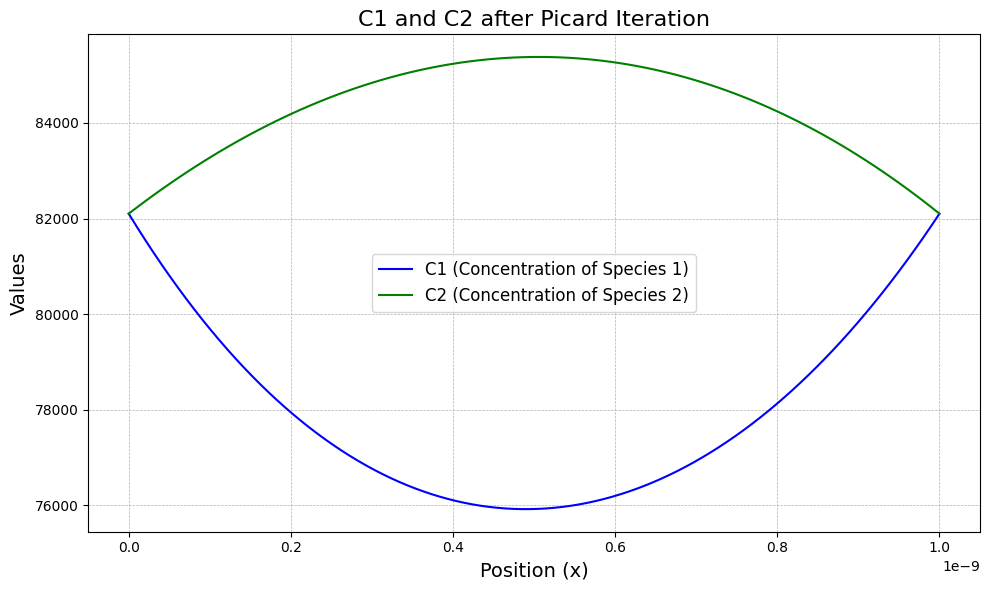

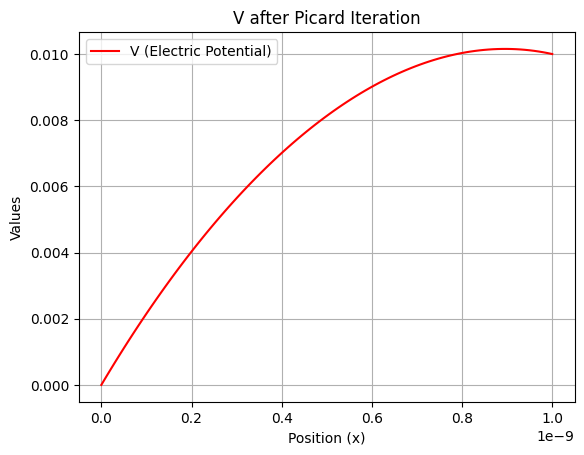

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(x_nodes, C1, label="C1 (Concentration of Species 1)", color="blue")
plt.plot(x_nodes, C2, label="C2 (Concentration of Species 2)", color="green")
# Plot labels and grid
plt.xlabel("Position (x)", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.title("C1 and C2 after Picard Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
plt.plot(x_nodes, V, label="V (Electric Potential)", color="red")
plt.xlabel("Position (x)")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.title("V after Picard Iteration")
plt.show()

# Mesh Convergence Study

Errors: [0, 11.78398107767769, 2.0161142217989063, 0.23188923157095728, 0.08048905336103723, 0.12631984406429314, 0.04038480649295987, 0.05598218931985487, 0.04106696848584324, 0.05482749898995386, 0.02412515760792435]


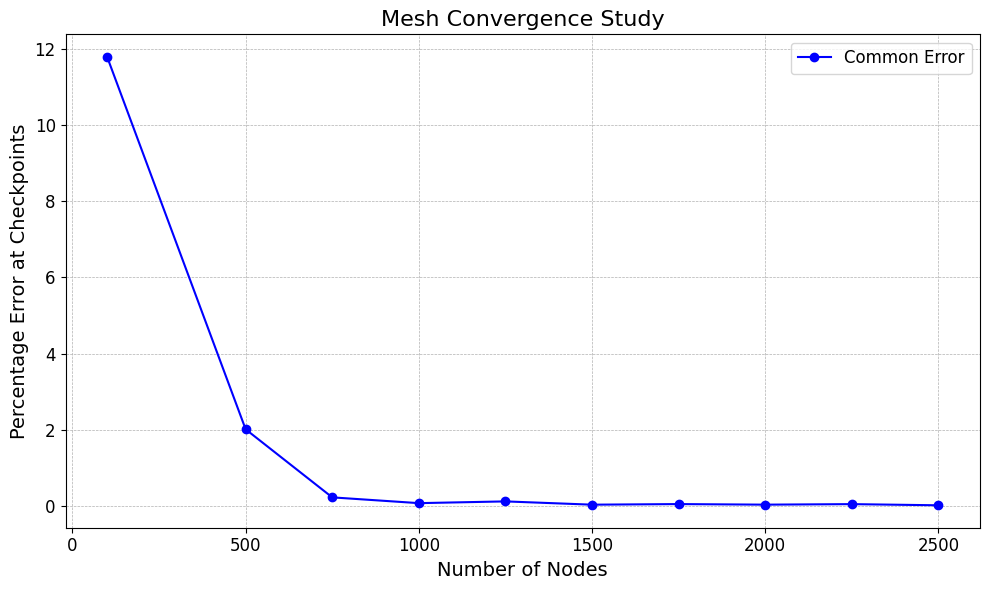

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
z1, z2 = 2, -1
k1, k2 = 12.514, 3.632e11
D1, D2 = 6.18e-9, 3.89e-7

# Parameters
num_gauss_points = 3
tol = 1e-9
max_iterations = 5
node_counts = [15, 100, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]  # Different numbers of nodes for the mesh convergence study

# Boundary conditions
V_left, V_right = 0, 0.133
C1_bc, C2_bc = 82101, 82101

def run_simulation(num_nodes):
    x_nodes = np.linspace(0, 1e-9, num_nodes)
    C1 = np.ones(num_nodes)
    C2 = np.ones(num_nodes)
    V = np.zeros(num_nodes)
    C1[0] = C1_bc
    C2[0] = C2_bc
    C1[-1] = C1_bc
    C2[-1] = C2_bc
    V[0] = V_left
    V[-1] = V_right
    L = assemble_global_L_matrix(x_nodes, num_gauss_points)

    for iteration in range(max_iterations):
        V_prev = V.copy()
        C1_prev = C1.copy()
        C2_prev = C2.copy()
        O = compute_O_matrix(x_nodes, C1, C2, z1, z2, num_gauss_points)
        V_rhs = k2 * O
        V[1:-1] = np.linalg.inv(L[1:-1, 1:-1]).dot(V_rhs[1:-1] - ((L[1:-1, 0] * V_left) + (L[1:-1, -1] * V_right)))
        M = compute_M_matrix(x_nodes, V, num_gauss_points)
        A1 = D1 * L + z1 * k1 * D1 * M
        A2 = D2 * L + z2 * k1 * D2 * M
        C1_rhs = np.zeros(num_nodes)
        C1_rhs[1:-1] = 0
        C1[1:-1] = np.linalg.inv(A1[1:-1, 1:-1]).dot(-((A1[1:-1, 0] * C1_bc) + (A1[1:-1, -1] * C1_bc)))
        C2_rhs = np.zeros(num_nodes)
        C2_rhs[1:-1] = 0
        C2[1:-1] = np.linalg.inv(A2[1:-1, 1:-1]).dot(-((A2[1:-1, 0] * C2_bc) + (A2[1:-1, -1] * C2_bc)))
        error = np.linalg.norm(C1 - C1_prev) / np.linalg.norm(C1_prev) + np.linalg.norm(C2 - C2_prev) / np.linalg.norm(C2_prev)
        if error < tol:
            break

    return V, C1, C2

errors = []
previous_values = None

for num_nodes in node_counts:
    # Define checkpoints dynamically
    check_points = np.array(
        [int(num_nodes * 0.125) + 1, int(num_nodes * 0.25) + 1, int(num_nodes * 0.5) + 1, int(num_nodes * 0.75) + 1, int(num_nodes * 0.875) + 1],
        dtype=int
    )

    # Run simulation for the current number of nodes
    V, C1, C2 = run_simulation(num_nodes)

    # Extract values at the specified checkpoints
    V_check = V[check_points]
    C1_check = C1[check_points]
    C2_check = C2[check_points]

    if previous_values is not None:
        # Compute percentage errors at checkpoints
        prev_V_check, prev_C1_check, prev_C2_check = previous_values
        percentage_error_V = np.linalg.norm(V_check - prev_V_check) / np.linalg.norm(prev_V_check) * 100
        percentage_error_C1 = np.linalg.norm(C1_check - prev_C1_check) / np.linalg.norm(prev_C1_check) * 100
        percentage_error_C2 = np.linalg.norm(C2_check - prev_C2_check) / np.linalg.norm(prev_C2_check) * 100

        # Combine errors
        common_error = percentage_error_V + percentage_error_C1 + percentage_error_C2
        errors.append(common_error)
    else:
        errors.append(0)

    # Update previous values
    previous_values = (V_check, C1_check, C2_check)

# Print errors for debugging
print("Errors:", errors)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.plot(node_counts[1:], errors[1:], marker='o', linestyle='-', color='b', label='Common Error')
plt.xlabel('Number of Nodes', fontsize=14)
plt.ylabel('Percentage Error at Checkpoints', fontsize=14)
plt.title('Mesh Convergence Study', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def compute_flux(x_nodes, c, V, D, z, k1, num_gauss_points):
    num_elements = len(x_nodes) - 1
    flux = np.zeros(num_elements)  # Store flux for each element

    for elem in range(num_elements):
        x1, x2 = x_nodes[elem], x_nodes[elem + 1]
        c1, c2 = c[elem], c[elem + 1]
        V1, V2 = V[elem], V[elem + 1]

        h = x2 - x1

        gauss_points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
        weights = np.array([1, 1])

        for i, gp in enumerate(gauss_points):
            xi = 0.5 * (1 + gp) * h + x1

            dN_dxi = np.array([-0.5, 0.5])

            J = h / 2
            inv_J = 2 / h

            dN_dx = dN_dxi * inv_J

            # Gradients in the current element
            grad_c = dN_dx[0] * c1 + dN_dx[1] * c2  # ∇c
            grad_V = dN_dx[0] * V1 + dN_dx[1] * V2  # ∇V

            flux_gp = -D * (grad_c + z * k1 * (c1 + c2) / 2 * grad_V)
            flux[elem] += flux_gp * weights[i] * J

    return flux

# Example usage
D1, D2 = 6.18e-9, 3.89e-7  # Diffusion coefficients for species 1 and 2
z1, z2 = 2, -1  # Charges for species 1 and 2
k1 = 12.514
num_gauss_points = 3

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
z1, z2 = 2, -1
k1, k2 = 12.514, 3.632e11
D1, D2 = 6.18e-9, 3.89e-7

# Parameters
num_gauss_points = 3
tol = 1e-9
max_iterations = 5
node_counts = [15, 100, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]  # Different numbers of nodes for the mesh convergence study

# Boundary conditions
V_left, V_right = 0, 0.133
C1_bc, C2_bc = 82101, 82101

def run_simulation(num_nodes):
    x_nodes = np.linspace(0, 1e-9, num_nodes)
    C1 = np.ones(num_nodes)
    C2 = np.ones(num_nodes)
    V = np.zeros(num_nodes)
    C1[0] = C1_bc
    C2[0] = C2_bc
    C1[-1] = C1_bc
    C2[-1] = C2_bc
    V[0] = V_left
    V[-1] = V_right
    L = assemble_global_L_matrix(x_nodes, num_gauss_points)

    for iteration in range(max_iterations):
        V_prev = V.copy()
        C1_prev = C1.copy()
        C2_prev = C2.copy()
        O = compute_O_matrix(x_nodes, C1, C2, z1, z2, num_gauss_points)
        V_rhs = k2 * O
        V[1:-1] = np.linalg.inv(L[1:-1, 1:-1]).dot(V_rhs[1:-1] - ((L[1:-1, 0] * V_left) + (L[1:-1, -1] * V_right)))
        M = compute_M_matrix(x_nodes, V, num_gauss_points)
        A1 = D1 * L + z1 * k1 * D1 * M
        A2 = D2 * L + z2 * k1 * D2 * M
        C1_rhs = np.zeros(num_nodes)
        C1_rhs[1:-1] = 0
        C1[1:-1] = np.linalg.inv(A1[1:-1, 1:-1]).dot(-((A1[1:-1, 0] * C1_bc) + (A1[1:-1, -1] * C1_bc)))
        C2_rhs = np.zeros(num_nodes)
        C2_rhs[1:-1] = 0
        C2[1:-1] = np.linalg.inv(A2[1:-1, 1:-1]).dot(-((A2[1:-1, 0] * C2_bc) + (A2[1:-1, -1] * C2_bc)))
        error = np.linalg.norm(C1 - C1_prev) / np.linalg.norm(C1_prev) + np.linalg.norm(C2 - C2_prev) / np.linalg.norm(C2_prev)
        if error < tol:
            break

    # Compute flux for the current simulation
    flux1 = compute_flux(x_nodes, C1, V, D1, z1, k1, num_gauss_points)
    flux2 = compute_flux(x_nodes, C2, V, D2, z2, k1, num_gauss_points)

    return V, C1, C2, flux1, flux2

errors = []
flux_errors = []
previous_values = None

for num_nodes in node_counts:
    # Define checkpoints dynamically
    check_points = np.array(
        [int(num_nodes * 0.125) + 1, int(num_nodes * 0.25) + 1, int(num_nodes * 0.5) + 1, int(num_nodes * 0.75) + 1, int(num_nodes * 0.875) + 1],
        dtype=int
    )

    # Run simulation for the current number of nodes
    V, C1, C2, flux1, flux2 = run_simulation(num_nodes)

    # Extract values at the specified checkpoints
    V_check = V[check_points]
    C1_check = C1[check_points]
    C2_check = C2[check_points]
    flux1_check = flux1[check_points-1]
    flux2_check = flux2[check_points-1]

    if previous_values is not None:
        # Compute percentage errors at checkpoints
        prev_V_check, prev_C1_check, prev_C2_check, prev_flux1_check, prev_flux2_check = previous_values
        percentage_error_V = np.linalg.norm(V_check - prev_V_check) / np.linalg.norm(prev_V_check) * 100
        percentage_error_C1 = np.linalg.norm(C1_check - prev_C1_check) / np.linalg.norm(prev_C1_check) * 100
        percentage_error_C2 = np.linalg.norm(C2_check - prev_C2_check) / np.linalg.norm(prev_C2_check) * 100
        percentage_error_flux1 = np.linalg.norm(flux1_check - prev_flux1_check) / np.linalg.norm(prev_flux1_check) * 100
        percentage_error_flux2 = np.linalg.norm(flux2_check - prev_flux2_check) / np.linalg.norm(prev_flux2_check) * 100

        # Combine errors
        common_error = percentage_error_V + percentage_error_C1 + percentage_error_C2
        flux_error = percentage_error_flux1 + percentage_error_flux2
        errors.append(common_error)
        flux_errors.append(flux_error)
    else:
        errors.append(0)
        flux_errors.append(0)

    # Update previous values
    previous_values = (V_check, C1_check, C2_check, flux1_check, flux2_check)

# Print errors for debugging
print("Errors:", errors)
print("Flux Errors:", flux_errors)

Errors: [0, 11.78398107767769, 2.0161142217989063, 0.23188923157095728, 0.08048905336103723, 0.12631984406429314, 0.04038480649295987, 0.05598218931985487, 0.04106696848584324, 0.05482749898995386, 0.02412515760792435]
Flux Errors: [0, 171.7180109565244, 160.32066440283288, 66.75567600159278, 50.050050746409326, 40.032025963284156, 33.35557057518911, 28.587764555200508, 25.01250633606555, 22.232103214408834, 20.00800323879714]


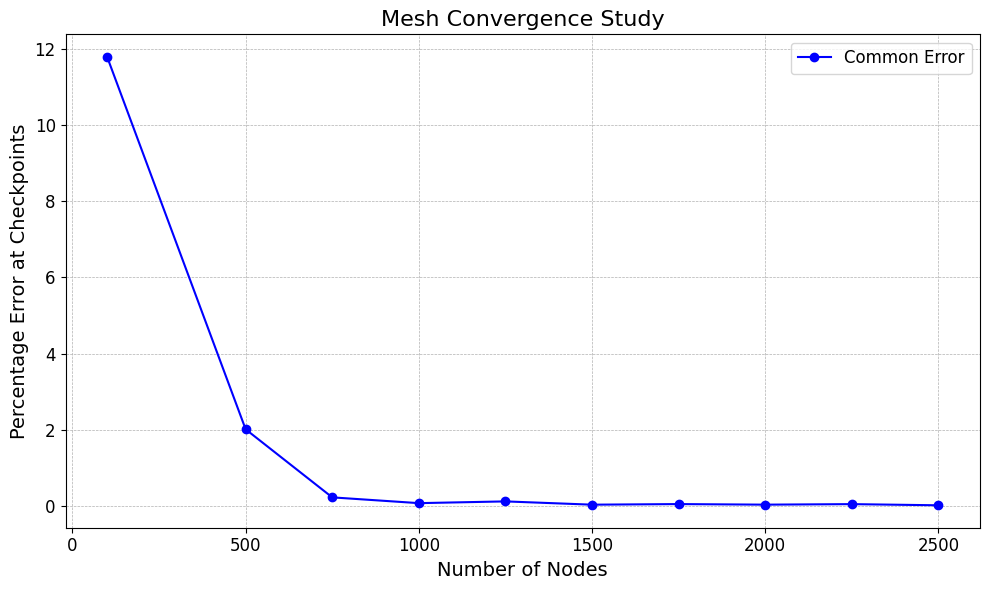

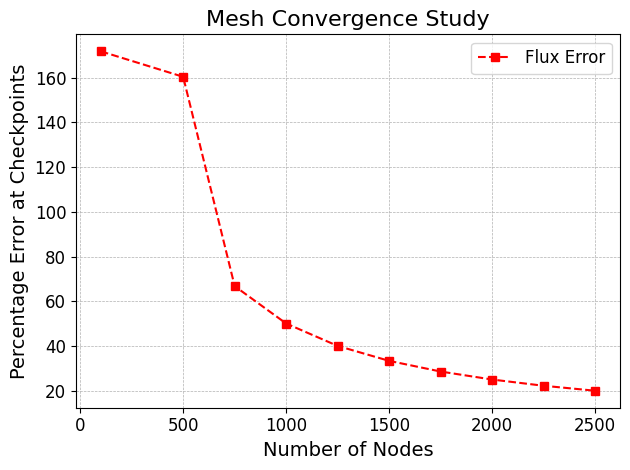

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(node_counts[1:], errors[1:], marker='o', linestyle='-', color='b', label='Common Error')
plt.xlabel('Number of Nodes', fontsize=14)
plt.ylabel('Percentage Error at Checkpoints', fontsize=14)
plt.title('Mesh Convergence Study', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
plt.plot(node_counts[1:], flux_errors[1:], marker='s', linestyle='--', color='r', label='Flux Error')
plt.xlabel('Number of Nodes', fontsize=14)
plt.ylabel('Percentage Error at Checkpoints', fontsize=14)
plt.title('Mesh Convergence Study', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

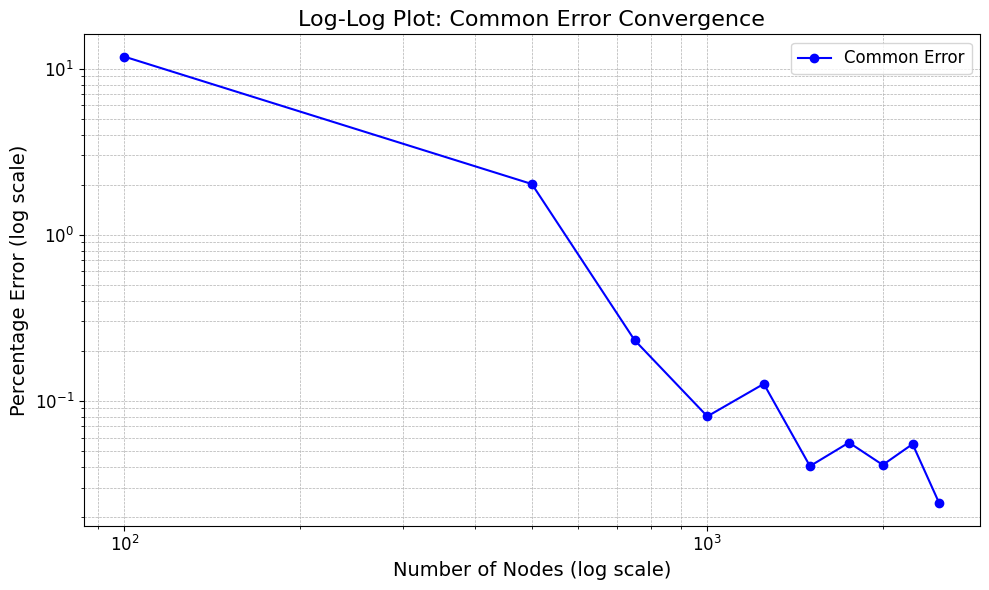

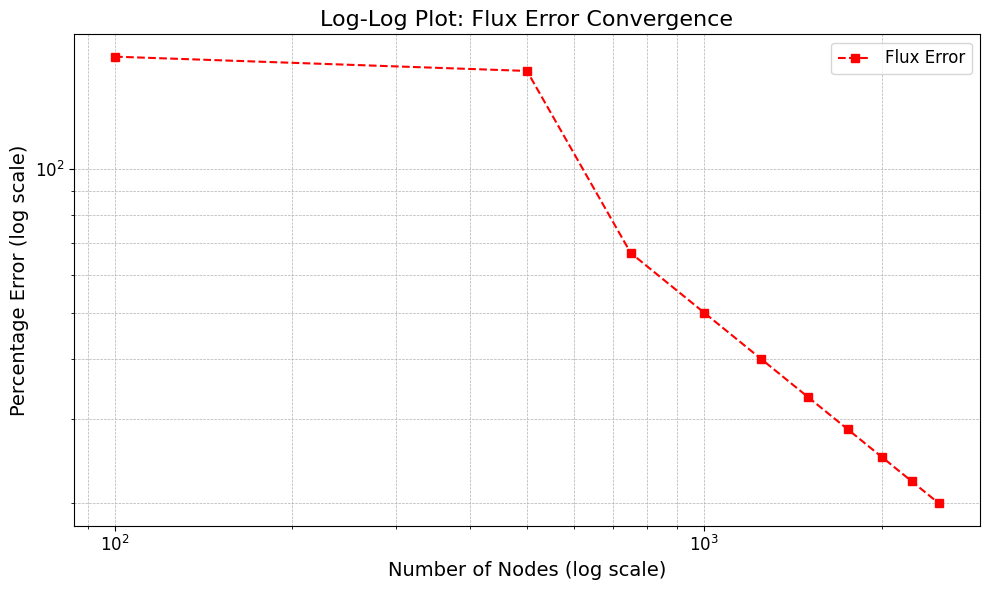

Convergence rate for Common Error: -1.97
Convergence rate for Flux Error: -1.20


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming node_counts, errors, and flux_errors are provided arrays
node_counts = np.array(node_counts[1:])
errors = np.array(errors[1:])
flux_errors = np.array(flux_errors[1:])

# Log-log plot for Common Error
plt.figure(figsize=(10, 6))
plt.loglog(node_counts, errors, marker='o', linestyle='-', color='b', label='Common Error')
plt.xlabel('Number of Nodes (log scale)', fontsize=14)
plt.ylabel('Percentage Error (log scale)', fontsize=14)
plt.title('Log-Log Plot: Common Error Convergence', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Log-log plot for Flux Error
plt.figure(figsize=(10, 6))
plt.loglog(node_counts, flux_errors, marker='s', linestyle='--', color='r', label='Flux Error')
plt.xlabel('Number of Nodes (log scale)', fontsize=14)
plt.ylabel('Percentage Error (log scale)', fontsize=14)
plt.title('Log-Log Plot: Flux Error Convergence', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Compute convergence rate (slope of the log-log data)
log_node_counts = np.log(node_counts)
log_errors = np.log(errors)
log_flux_errors = np.log(flux_errors)

# Linear regression for Common Error
slope_error, intercept_error, _, _, _ = linregress(log_node_counts, log_errors)

# Linear regression for Flux Error
slope_flux_error, intercept_flux_error, _, _, _ = linregress(log_node_counts[1:], log_flux_errors[1:])

print(f"Convergence rate for Common Error: {slope_error:.2f}")
print(f"Convergence rate for Flux Error: {slope_flux_error:.2f}")
